In [56]:
# set root dir in system path
import sys
sys.path.insert(0, '/Users/dish/Code/codeQual')
print(sys.path)
from codeQual import set_device
device = set_device.set()

['/Users/dish/Code/codeQual', '/Users/dish/Code/codeQual', '/Users/dish/Code/codeQual', '/Users/dish/Code/codeQual', '/Users/dish/Code/codeQual', '/Users/dish/Code/codeQual/notebooks', '/Users/dish/anaconda3/envs/codequal/lib/python310.zip', '/Users/dish/anaconda3/envs/codequal/lib/python3.10', '/Users/dish/anaconda3/envs/codequal/lib/python3.10/lib-dynload', '', '/Users/dish/anaconda3/envs/codequal/lib/python3.10/site-packages', '/var/folders/52/649zlcmd67lcyfjp21c25b5m0000gn/T/tmpbdlrkj0i']


In [57]:
MODEL_NAME = '../experiments/epoch10batch1wr0.2data1/checkpoint-13100'
DATESET = '../data/hf_code_qual_dataset_v1'

In [58]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = MODEL_NAME
num_classes = 3
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes, max_length=512).to(device)
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
tokenizer.add_special_tokens({"pad_token": "[PAD]"})

1

In [59]:
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict, load_dataset
code_qual_dataset = DatasetDict.load_from_disk(DATESET)

def tokenize(batch):
    return tokenizer(batch["submission"], padding=True, truncation=True)


codequal_encoded: DatasetDict = code_qual_dataset.map(tokenize, batched=True, batch_size=None)
codequal_encoded

DatasetDict({
    train: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1650
    })
    validation: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 300
    })
    test: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 300
    })
})

In [60]:
from torch.nn.functional import cross_entropy
import torch

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [61]:
# Convert our dataset back to PyTorch tensors

codequal_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
codequal_encoded["test"] = codequal_encoded["test"].map(forward_pass_with_label, batched=True, batch_size=4)
codequal_encoded["validation"] = codequal_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=4)
codequal_encoded

Map: 100%|██████████| 300/300 [00:06<00:00, 47.46 examples/s]


DatasetDict({
    train: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1650
    })
    validation: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
        num_rows: 300
    })
    test: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
        num_rows: 300
    })
})

In [62]:
codequal_encoded.set_format("pandas")
cols = ["problem", "submission", "label", "predicted_label", "loss"]
df_test = codequal_encoded["test"][:][cols]
df_val = codequal_encoded["validation"][:][cols]
df_test

,problem,submission,label,predicted_label,loss
0,An integer N is a multiple of 9 if and only if...,target = input()\nsum = 0\nfor each in target:...,2,0,5.999688
1,Snuke is having a barbeque party.\nAt the part...,import sys\ninput=sys.stdin.readline\n\nN = in...,2,2,0.099974
2,Write a program which prints $n$-th fibonacci ...,n = int(input())\nl = [0 for _ in range(10**4)...,2,0,6.211662
3,Takahashi is meeting up with Aoki.\nThey have ...,"D, T, S = map(int, input().split())\n\nif (D /...",2,1,7.154482
4,You can obtain profits from foreign exchange m...,s_max = -float('inf')\ns = 0\nfor i in range(i...,2,2,0.005213
...,...,...,...,...,...
295,There are N positive integers written on a bla...,n=int(input())\na=[int(i)for i in input().spli...,0,0,0.133195
296,Given are two strings S and T.\nLet us change ...,S = list(str(input()))\nT = list(str(input()))...,0,0,0.000810
297,"In some other world, today is Christmas.\nMr. ...","N, X = map(int, input().split())\ndim, ans = [...",0,0,0.002860
298,There are N integers written on a blackboard. ...,"n = int(input())\nA = list(map(int,input().spl...",0,0,0.007270


In [63]:
df_loss_desc = df_test.sort_values("loss", ascending=False).head(10)
df_loss_desc

,problem,submission,label,predicted_label,loss
39,Snuke is having a barbeque party.\nAt the part...,"n = int(input())\nL = list(map(int, input().sp...",2,0,8.889094
67,N people are arranged in a row from left to ri...,"n, k = map(int, input().split())\ns = input()\...",2,0,8.626630
34,You are an immigration officer in the Kingdom ...,# -*- coding: utf-8 -*-\nN = int(input())\nA =...,2,0,8.459834
274,We will play a one-player game using a number ...,"n, m = map(int, input().split())\nx = list(map...",0,1,8.381775
52,Takahashi lives in another world. There are sl...,"N = int(input())\nA = list(map(int, input().sp...",2,0,8.352122
98,Given is a string S. Each character in S is ei...,"""""""\ndp[i][j] => 下からi桁目まで見る。あまりがjになるような数。\n""""""...",2,0,8.334899
96,You are given N items.\nThe value of the i-th ...,"import math\n\ndef nCr(n,r):\n return math....",2,0,8.084675
11,There are N Reversi pieces arranged in a row. ...,"from math import ceil,floor,comb,factorial,gcd...",2,0,8.077841
219,You are given a string S consisting of lowerca...,S = str(input())\ni = 0\nerror = 0\n\nwhile i ...,0,2,8.040564
249,"There are N children, numbered 1, 2, ..., N.\n...",import sys\n\nsys.setrecursionlimit(10 ** 8)\n...,0,2,8.028150


In [64]:
# save df_loss_desc to latex table
# truncate the submission and problem column to 50 characters
df_loss_desc['submission'] = df_loss_desc['submission'].str[:50] + '...'
df_loss_desc['problem'] = df_loss_desc['problem'].str[:50] + '...'
df_loss_desc.to_latex('df_loss_desc.tex', index=False)

In [65]:
df_loss_asc = df_test.sort_values("loss", ascending=True).head(10)
df_loss_asc

,problem,submission,label,predicted_label,loss
291,There are N positive integers written on a bla...,"N = int(input())\nA = list(map(int, input().sp...",0,0,0.000708
245,There are N positive integers written on a bla...,"n=int(input())\na=list(map(int, input().split(...",0,0,0.000712
214,"We have sticks numbered 1, \cdots, N. The leng...",# coding: utf-8\nn = int(input())\nL = list(ma...,0,0,0.000715
206,"In this problem, we only consider strings cons...","def p(S):\n str = """"\n for s in S:\n ...",0,0,0.000715
269,There are N positive integers written on a bla...,"N = int(input())\nx = map(int,input().split()...",0,0,0.000728
255,Takahashi will take part in an eating contest....,import sys\n\nreadline = sys.stdin.readline\nM...,0,0,0.000733
248,You are given a string S consisting of lowerca...,s = input()\nS = ''.join(list(reversed(s)))\nN...,0,0,0.000739
272,"We have a sequence of N integers A~=~A_0,~A_1,...","n,k = map(int,input().split())\na = list(map(i...",0,0,0.000739
294,Tak has N cards. On the i-th (1 \leq i \leq N)...,"n,*x=map(int,open(0).read().split())\ny=[x[0]-...",0,0,0.000751
280,There are N positive integers written on a bla...,"n = int(input())\na = map(int, input().split()...",0,0,0.000758


In [66]:
# save df_loss_desc to latex table
# truncate the submission and problem column to 50 characters
df_loss_asc['submission'] = df_loss_asc['submission'].str[:50] + '...'
df_loss_asc['problem'] = df_loss_asc['problem'].str[:50] + '...'
df_loss_asc.to_latex('df_loss_asc.tex', index=False)

In [67]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    return accuracy, f1, precision, recall

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [69]:
import numpy as np

Y_test = np.array(df_test["label"])
Y_test_preds = np.array(df_test["predicted_label"])

Y_val = np.array(df_val["label"])
Y_val_preds = np.array(df_val["predicted_label"])

Y_test.shape, Y_test_preds.shape

((300,), (300,))

In [70]:
print("Test scores:")
print(evaluate(Y_test, Y_test_preds))
print("Validation scores:")
print(evaluate(Y_val, Y_val_preds))

Test scores:
(0.5033333333333333, 0.4872398964981229, 0.49735135961970645, 0.5033333333333333)
Validation scores:
(0.5666666666666667, 0.5565489138537185, 0.5588857886825402, 0.5666666666666667)


['low', 'average', 'high']


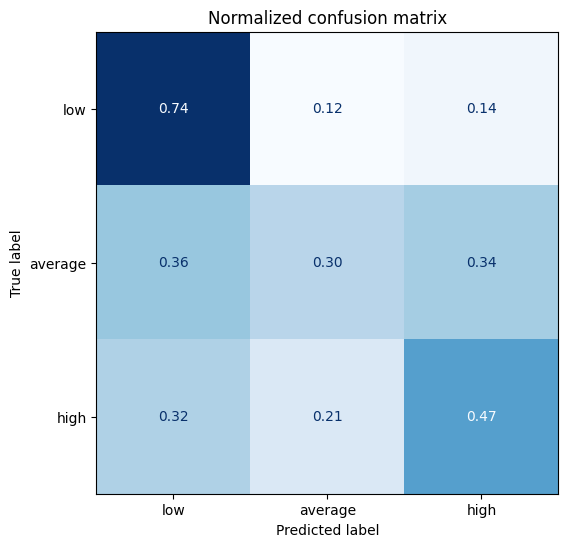

In [71]:
labels = code_qual_dataset['train'].features["label"].names
print(labels)
plot_confusion_matrix(Y_test_preds, Y_test, labels)

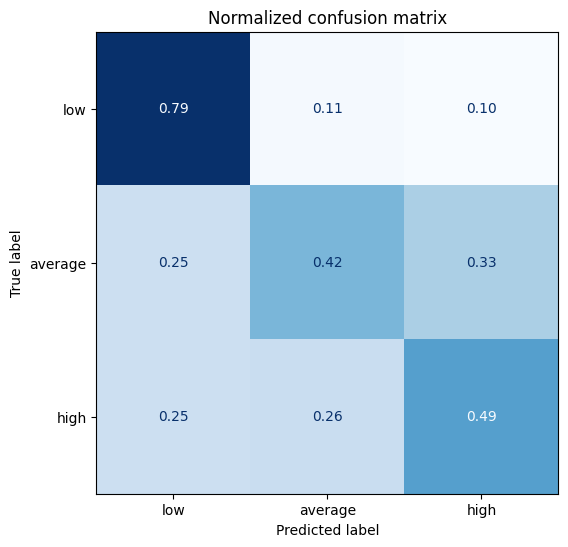

In [72]:
plot_confusion_matrix(Y_val_preds, Y_val, labels)

# Side by side comparison of confusion matrices between the baseline and the CodeQualBert

| Baseline | CodeQualBert |
| -------- | ------------ |
| ![Baseline](../images/confusion_matrix_baseline.png) |  ![CodeQualBert](../images/confusion_matrix_codequalbert.png) |
